In [1]:
import cv2

img = cv2.imread('images/solar_Fri_Jun_16_6__0__25_2017_L_0.0901960784314_I_0.003.jpg')

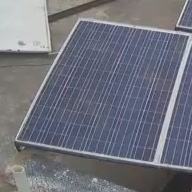

In [2]:
import IPython

def imshow(img):
    returnValue, buffer = cv2.imencode('.jpg', img)
    IPython.display.display(IPython.display.Image(data=buffer.tobytes()))

imshow(img)

height, width, channels = img.shape

[[ 0.17820326]
 [ 0.21052227]
 [ 0.22254894]
 [ 0.21052227]
 [ 0.17820326]]


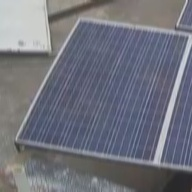

Time Taken: 1.5833227634429932 
 
*** Profile printout saved to text file 'prunSW'. 


In [3]:
%%prun -s cumulative -q -l 10 -T prunSW
import numpy as np
import time

#Sobel Hor filter  
kernelV    = np.array([[-1.0,-2.0,-1.0],[0.0,0.0,0.0],[1.0,2.0,1.0]],np.float32)
kernelH    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
kernelG    = np.array([[1.0,2.0,1.0],[2.0,4.0,2.0],[1.0,2.0,1.0]],np.float32)
kernelD   = np.ones((3,3),np.uint8)
buf       = np.ones((height,width),np.uint8)
frame_out = np.ones((height,width),np.uint8)

num_frames    = 20

gaussian_kernel = cv2.getGaussianKernel(5,3)
print(gaussian_kernel)
# kernel_2D = gaussian_kernel @ gaussian_kernel.transpose()

start = time.time()
frame_in_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
# cv2.filter2D(img, -1, kernelG, buf, borderType=cv2.BORDER_CONSTANT)
blurred=cv2.filter2D(img, -1, gaussian_kernel)
# cv2.dilate(buf, kernelD, frame_out, borderType=cv2.BORDER_CONSTANT)
imshow(blurred)

time_sw_total = time.time() - start
print("Time Taken: {} ".format(time_sw_total))

In [5]:
print(open('prunSW','r').read())
res = !cat prunSW | grep filter2D | awk '{{print $$2}}'
tottime_sw_filter2d = float(res[0])
res = !cat prunSW | grep dilate   | awk '{{print $$2}}'
tottime_sw_dilate   = float(res[0])

         1356 function calls (1346 primitive calls) in 1.654 seconds

   Ordered by: cumulative time
   List reduced from 209 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    1.654    1.654 {built-in method builtins.exec}
        1    0.000    0.000    1.652    1.652 <string>:2(<module>)
        1    1.019    1.019    1.019    1.019 {filter2D}
        1    0.554    0.554    0.554    0.554 {cvtColor}
        1    0.065    0.065    0.065    0.065 {getGaussianKernel}
        1    0.000    0.000    0.010    0.010 <ipython-input-2-4f1120b9b77c>:3(imshow)
        1    0.000    0.000    0.008    0.008 display.py:141(display)
        1    0.000    0.000    0.005    0.005 display.py:83(publish_display_data)
        1    0.000    0.000    0.004    0.004 zmqshell.py:94(publish)
        2    0.000    0.000    0.003    0.002 {built-in method builtins.print}


IndexError: list index out of range

In [6]:
import cv2 #NOTE: This needs to be loaded first

# Load filter2D + dilate overlay
from pynq import Overlay
bs = Overlay("/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.bit")
bs.download()
import pynq_cv.overlays.xv2Filter2DDilate as xv2

# Load xlnk memory manager
from pynq import Xlnk
Xlnk.set_allocator_library('/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.so')
mem_manager = Xlnk()

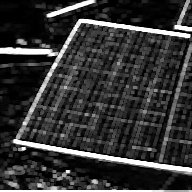

Time Taken:  0.011149883270263672
 
*** Profile printout saved to text file 'prunHW'. 


In [7]:
%%prun -s tottime -q -l 10 -T prunHW
import numpy as np
import time

#Sobel Hor filter  
kernelF    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
kernelVoid = np.zeros(0)
xFin       = mem_manager.cma_array((height,width),np.uint8)
xFbuf      = mem_manager.cma_array((height,width),np.uint8)
xFout      = mem_manager.cma_array((height,width),np.uint8)

num_frames       = 20

xFin[:]    = frame_in_gray[:]

start = time.time()
frame_in_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
xFin[:]       = frame_in_gray[:]
xv2.filter2D(xFin, -1, kernelF, xFbuf, borderType=cv2.BORDER_CONSTANT)
xv2.dilate(xFbuf, kernelVoid, xFout, borderType=cv2.BORDER_CONSTANT)
frame_out[:]  = xFout[:]
imshow(frame_out)

time_hw_total = time.time() - start
print("Time Taken:  " + str(time_hw_total))